This program uses an artificial recurrent neural network called Long Short Term Memeory (LSTM)
to predict the closing stock price of a corporation (Apple Inc). using the past 60 day stock price.

In [1]:
#Import libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras.callbacks
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
import yfinance as yf
import keras.optimizers
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
#Get the stock quote || Data cleaning
data = yf.download(tickers='TSLA', start= '2018-01-01', end = '2022-12-31')
data.drop(['Volume'], axis=1, inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close
Date,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668
2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000
2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667
2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333
2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334


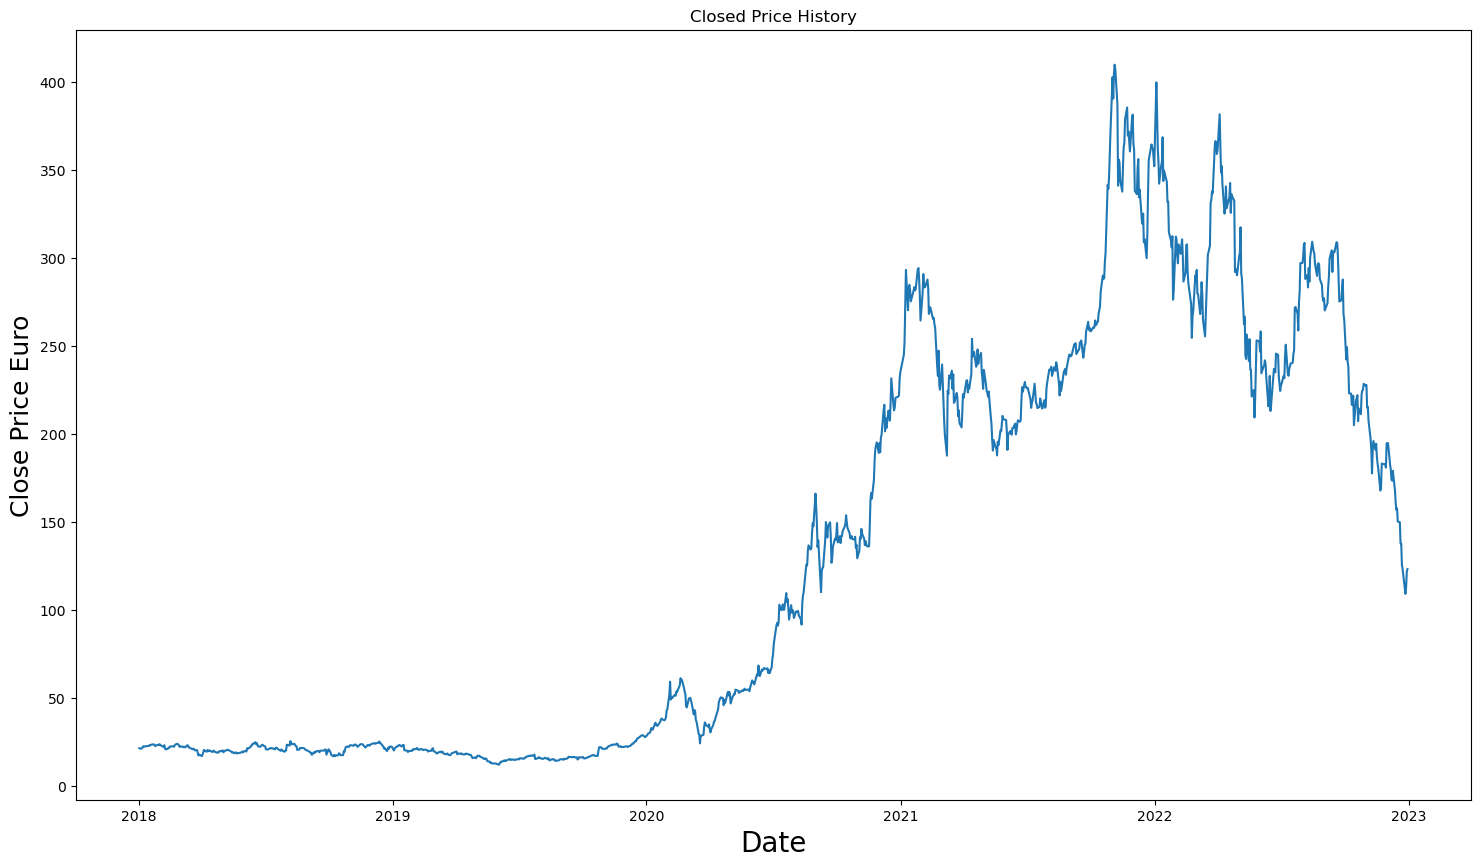

In [3]:
#Visualize the colsing price history
plt.figure(figsize=(18,10))
plt.title('Closed Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price Euro', fontsize=18)
plt.show()

In [4]:
#Adding Indicators
data['Target'] = data['Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)

In [5]:
data_set = data.iloc[:, 1:11]#.values
pd.set_option('display.max_columns', None)
data_set.head(20)

,Open,High,Low,Close,Adj Close,Target,TargetNextClose
0,20.799999,21.474001,20.733334,21.368668,21.368668,-0.250000,21.150000
1,21.400000,21.683332,21.036667,21.150000,21.150000,0.116667,20.974667
2,20.858000,21.236668,20.378668,20.974667,20.974667,-0.002666,21.105333
3,21.108000,21.149332,20.799999,21.105333,21.105333,1.360666,22.427334
4,21.066668,22.468000,21.033333,22.427334,22.427334,-0.098000,22.246000
5,22.344000,22.586666,21.826668,22.246000,22.246000,0.173332,22.320000
6,22.146667,22.466667,22.000000,22.320000,22.320000,0.180668,22.530001
7,22.349333,22.987333,22.217333,22.530001,22.530001,-0.160666,22.414667
8,22.575333,22.694000,22.244667,22.414667,22.414667,0.168001,22.670668
9,22.502666,23.000000,22.320000,22.670668,22.670668,0.445999,23.143999


In [6]:
data.dtypes

Date               datetime64[ns]
Open                      float64
High                      float64
Low                       float64
Close                     float64
Adj Close                 float64
Target                    float64
TargetNextClose           float64
dtype: object

In [7]:
#Get the number of rows and column in the data set
data.shape

(1258, 8)

In [8]:
#Create a new dataframe with only the 'Close' column
data = data.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .7) #70% or 80% of 1259 and rounded up which needs to = 882 or 1007

print(training_data_len)

881


In [9]:
#Scale the data (its advantage to apply preprocessing scaling or normalziation to the input data before it is presented to a neural network and it usallu hepts the model aswell)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data


array([[0.02370959],
       [0.02316023],
       [0.02271974],
       ...,
       [0.24411866],
       [0.25318813],
       [0.27607536]])

In [10]:
#Create the training data set
#1. Create the scaled training data set
train_data = scaled_data[0:training_data_len , :] #contining all the values of index 0 of training data len

#split the data into x_train and y_train data sets
x_train = [] #indipented training variables
y_train = [] #dependent variable / target variable

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.02370959, 0.02316023, 0.02271974, 0.02304801, 0.0263693 ,
       0.02591373, 0.02609964, 0.02662723, 0.02633748, 0.02698063,
       0.02816979, 0.027736  , 0.02864881, 0.02890674, 0.02911275,
       0.02795709, 0.02657531, 0.02744792, 0.02856674, 0.02794536,
       0.02936733, 0.02851984, 0.02759866, 0.02581994, 0.02596063,
       0.02780802, 0.0228219 , 0.02201629, 0.02290565, 0.02423383,
       0.02400772, 0.02597738, 0.02621521, 0.02609462, 0.02584841,
       0.02800398, 0.02898881, 0.02988822, 0.02881127, 0.02748309,
       0.02545147, 0.02615324, 0.02585679, 0.02499422, 0.02568092,
       0.02514496, 0.02482171, 0.02789344, 0.02727876, 0.02473127,
       0.02455876, 0.02384693, 0.0225422 , 0.02203806, 0.02303964,
       0.0217952 , 0.020529  , 0.02097117, 0.01678396, 0.01319972])]
[0.014598249993150625]

[array([0.02370959, 0.02316023, 0.02271974, 0.02304801, 0.0263693 ,
       0.02591373, 0.02609964, 0.02662723, 0.02633748, 0.02698063,
       0.02816979, 0.027736  , 0.0

In [11]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

#Output: 3 dimensional shape for our dataset as LSTM required 3 dimensions

(821, 60, 1)

In [12]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
#Train the model
model.fit(x_train, y_train, batch_size=10, epochs=100) #Epochs is the number of iterations when an entire dataset is passed foward and backward through a neural network


Epoch 1/100
83/83 [==============================] - 6s 23ms/step - loss: 0.0028
Epoch 2/100
83/83 [==============================] - 2s 23ms/step - loss: 6.8320e-04
Epoch 3/100
83/83 [==============================] - 2s 23ms/step - loss: 7.0601e-04
Epoch 4/100
83/83 [==============================] - 2s 23ms/step - loss: 6.6468e-04
Epoch 5/100
83/83 [==============================] - 2s 26ms/step - loss: 5.4869e-04
Epoch 6/100
83/83 [==============================] - 2s 27ms/step - loss: 4.7984e-04
Epoch 7/100
83/83 [==============================] - 2s 27ms/step - loss: 4.2188e-04
Epoch 8/100
83/83 [==============================] - 2s 27ms/step - loss: 4.7846e-04
Epoch 9/100
83/83 [==============================] - 2s 24ms/step - loss: 3.8574e-04
Epoch 10/100
83/83 [==============================] - 2s 23ms/step - loss: 4.4977e-04
Epoch 11/100
83/83 [==============================] - 2s 23ms/step - loss: 4.5497e-04
Epoch 12/100
83/83 [==============================] - 2s 23ms/step 

In [15]:
#Create the testing data set
#Create a new array containing scaled values from index 
test_data = scaled_data[training_data_len - 60:, :]

#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [16]:
#Convert the data to a numpy array
x_test = np.array(x_test) #the socpe os using np.array is so we can use it in the LSTM model

In [17]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 1s 11ms/step


In [19]:
#Get the root mean squared error (RMSE) it measures how accurate the model predicts the response and its standard deviation.
rmse=np.sqrt(np.mean(((predictions - y_test)**2).mean()))
rmse

14.038015642580458

In [20]:
#Get the Mean Squared Error
MSE = ((predictions - y_test) ** 2).mean()
MSE

197.06588318133362

In [21]:
#MSPE
MAPE = mean_absolute_percentage_error(y_test, predictions) * 100
MAPE

3.8371730930917294

C:\Users\User\AppData\Local\Temp\ipykernel_4472\2321885292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


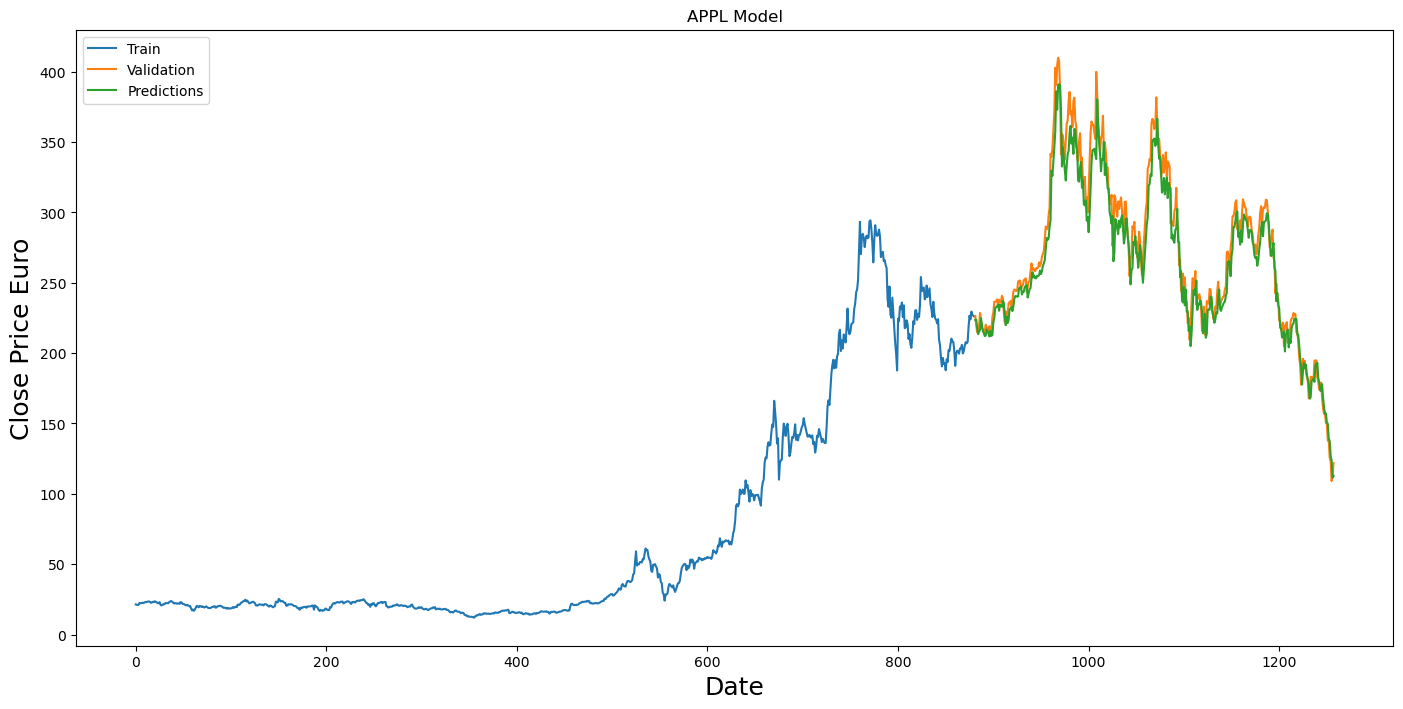

In [23]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(17,8))
plt.title('APPL Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Euro', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions',]])
plt.legend(['Train', 'Validation', 'Predictions'], loc='upper left')
plt.show()

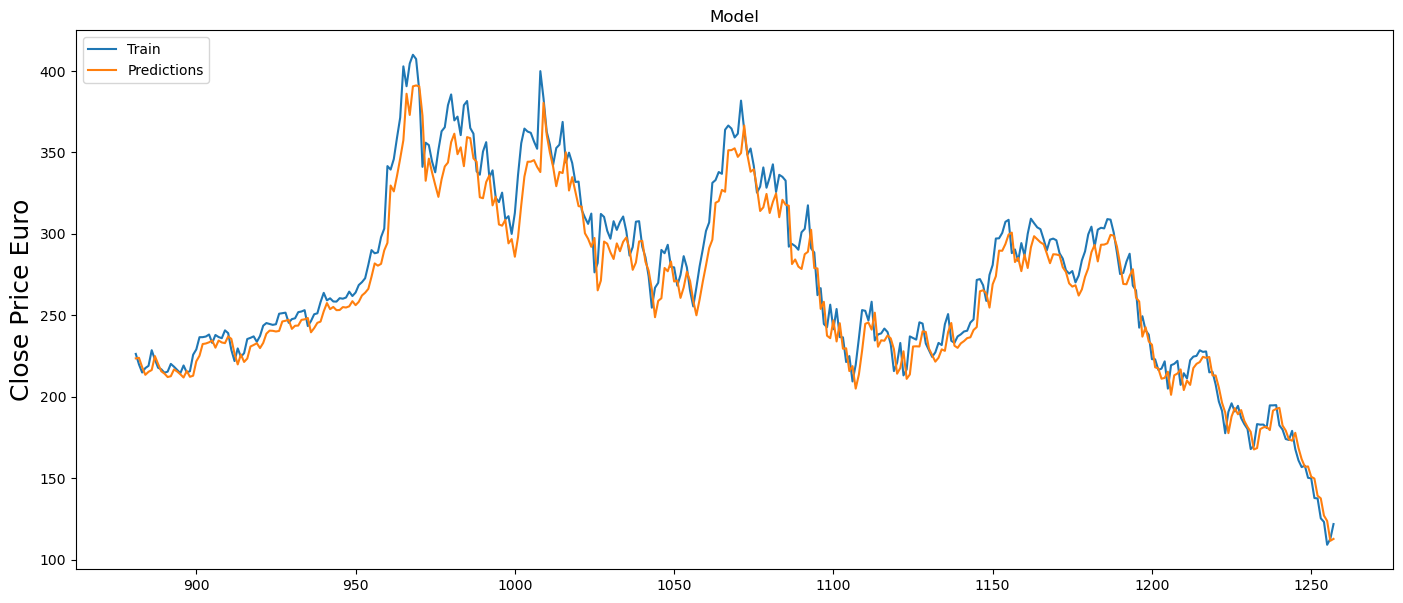

In [24]:
plt.figure(figsize=(17,7))
plt.title('Model')
plt.ylabel('Close Price Euro', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Predictions'], loc='upper left')
plt.show()

In [26]:
valid.head(20) #close price vs the forcasting closing price

,Close,Predictions
881,226.300003,223.557098
882,219.860001,223.893784
883,214.883331,218.154694
884,217.603333,213.462921
885,218.983337,215.314911
886,228.566666,216.396133
887,222.846664,224.961288
888,217.793335,220.121017
889,216.866669,215.646561
890,214.740005,214.209641
